In [1]:
# basic dependencies

# basic dependencies


import numpy as np
from numpy import loadtxt
from numpy import savetxt
import os

import pandas as pd
import math
import time
from datetime import datetime, date
import scipy
from scipy import signal
from scipy.optimize import curve_fit

import re
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

from gpytorch.constraints import GreaterThan
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
class BO_LiqTransfer:

    def __init__(self, liquid_name):
        self.liquid_name = liquid_name
        self._data = None
        self.features = ['aspiration_rate','dispense_rate']
        self.objectives = ['%error','time_asp_1000']
        self.bmax = 1.25
        self.bmin = 0.1
        self._latest_suggestion = None
        self._latest_volume = None
        self._latest_acq_value = None
        self.mean_volumes = [300,500,1000]
    
   
    def set_data(self,df):
        df['time_asp_1000'] = 1000/df['aspiration_rate'] + 1000/df['dispense_rate'] + df['delay_aspirate'] + df['delay_dispense']
        if 'acq_value' not in df.columns:
            df['acq_value'] = None

        if df.loc[:,self.features].duplicated().sum()==0:
            df_mean = df
        else:
            df_duplicates = df.where(df.duplicated(self.features,keep=False)==True).dropna(how='all')
            df_incomplete = df.where(df.duplicated(self.features,keep=False)==False).dropna(how='all')
            df_mean = pd.DataFrame(columns= df.columns)
            for index,values in df_duplicates.drop_duplicates(self.features).iterrows():
                if len(df_duplicates.loc[index:index+2]) == len(self.mean_volumes):
                    mean_error =df_duplicates.loc[index:index+2,'%error'].abs().mean()
                    df_duplicates.loc[index,'%error'] = -mean_error
                    df_duplicates.loc[index, 'volume'] ='mean'+str(self.mean_volumes)
                    df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
                    
                else:
                    df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
            df_mean = pd.concat([df_mean,df_incomplete])
            df_mean = df_mean.reset_index(drop=True)    
        self._data = df_mean
 
        



    def data_from_csv(self,file_name):
        data = pd.read_csv(file_name)
        self.set_data(data)



    def update_data(self,df):
        self._latest_volume = df['volume'].iloc[-1]
        updated_data = pd.concat([self._data,df],ignore_index=True)
        self.set_data(updated_data)
        return self._data
                                

    def xy_split(self):
        df_train = self._data.where(self._data['volume']=='mean'+str(self.mean_volumes)).dropna(how='all')
        x_train = df_train[self.features]
        y_train = df_train[self.objectives]
        return x_train,y_train

    def set_bounds(self, x_train):
        return torch.vstack([x_train[0]*self.bmin, x_train[0]*self.bmax])



    def fit_surrogate(self):
        x_train, y_train = self.xy_split()
        x_train = torch.tensor(x_train.to_numpy(dtype=float), **tkwargs)
        y_train = torch.tensor(y_train.to_numpy(dtype=float), **tkwargs)
        y_train[:,0] = -torch.absolute(y_train[:,0])
        y_train[:,1] = -torch.absolute(y_train[:,1])

        problem_bounds = self.set_bounds(x_train)
        time_upper = 1000/problem_bounds[0][0] +1000/problem_bounds[0][1] + 10
        error_upper = y_train[:,0].abs().min()*1.25
        ref_point = torch.tensor([-error_upper,-time_upper], **tkwargs)

        train_x_gp = normalize(x_train, problem_bounds)
        models = []
        for i in range(y_train.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, y_train[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model1 = ModelListGP(*models)
        mll1 = SumMarginalLogLikelihood(model1.likelihood, model1)

        fit_gpytorch_model(mll1)
    
        return model1, ref_point, train_x_gp, problem_bounds
    
    def optimized_suggestions(self, random_state= 42):
        if random_state != None:
            torch.manual_seed(random_state) 
        standard_bounds = torch.zeros(2, len(self.features), **tkwargs)
        standard_bounds[1] = 1
        model1, ref_point, train_x_gp, problem_bounds = self.fit_surrogate()
        acq_func1 = qNoisyExpectedHypervolumeImprovement(
        model=model1,
        ref_point=ref_point, # for computing HV, must flip for BoTorch
        X_baseline=train_x_gp, # feed total list of train_x for this current iteration
        sampler=SobolQMCNormalSampler(sample_shape=512),  # determines how candidates are randomly proposed before selection
        objective=IdentityMCMultiOutputObjective(outcomes=np.arange(len(self.objectives)).tolist()), # optimize first n_obj col 
        prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        sobol1 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol2 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol_all = torch.vstack([sobol1, sobol2])
            
        acq_value_list = []
        for i in range(0, sobol_all.shape[0]):
            with torch.no_grad():
                acq_value = acq_func1(sobol_all[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())
                
        # filter the best 12 QMC candidates first
        sorted_x = sobol_all.cpu().numpy()[np.argsort((acq_value_list))]
        qnehvi_x = torch.tensor(sorted_x[-12:], **tkwargs)  
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(qnehvi_x, bounds=problem_bounds)
        new_x = pd.DataFrame(new_x.numpy(),columns=['aspiration_rate','dispense_rate'])
        new_x['acq_value'] = sorted(acq_value_list, reverse=True)[:12]
        self._latest_suggestion = new_x[['aspiration_rate','dispense_rate']].iloc[0]
        self._latest_acq_value = new_x['acq_value'].iloc[0]
        return new_x






In [3]:
#Import robot related packages and run setup
import pandas as pd
import time
from matplotlib import pyplot as plt
from pathlib import Path
import sys
REPOS = 'GitHub'
ROOT = str(Path().absolute()).split(REPOS)[0]
sys.path.append(f'{ROOT}{REPOS}')

from polylectric.configs.SynthesisB1 import SETUP, LAYOUT_FILE

from controllably import load_deck      # optional
load_deck(SETUP.setup, LAYOUT_FILE)     # optional

platform = SETUP
platform.mover.verbose = False #askpablo

Import: OK <controllably.misc.decorators>
Import: OK <controllably.misc.helper>
Import: OK <controllably.misc.factory>
Import: OK <controllably.misc.layout>
Import: OK <controllably.misc.logger>
Import: OK <controllably.misc.misc_utils>


Import: OK <controllably.Compound.compound_utils>
Import: OK <controllably.Compound.LiquidMover.liquidmover_utils>


Import: OK <controllably.Move.move_utils>
Import: OK <controllably.Move.Jointed.jointed_utils>
Import: OK <controllably.Move.Jointed.Dobot.dobot_utils>
Import: OK <controllably.Move.Jointed.Dobot.m1pro_utils>
Import: OK <controllably.Move.Jointed.Dobot.mg400_utils>
ClearError()
receive: ClearError()
EnableRobot()
receive: EnableRobot()
User(0)
receive: User(0)
Tool(0)
receive: Tool(0)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
Infeasible coordinates! (0.0, 0.0, 200.0)
Infeasible coordinates! (300.0, 1.1368683772161603e-13, 0.0)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 3.000s (1.000x

In [4]:
#Initialization of variables for platform objects
pipette= platform.setup
deck = platform.setup.deck
balance = platform.balance
balance_deck = deck.slots['1']
source = deck.slots['2']
tip_rack = deck.slots['3']
bin = deck.slots['4']
pipette.mover.setSpeed(50)
print(balance_deck)
print(source)
print(tip_rack)
print(bin)

#Check if balance is connected
balance.zero() #to tare
balance.toggleRecord(True) # turn on and record weight
time.sleep(5) # do previous action for 5s
print(balance.buffer_df.iloc[-1]) #iloc can take -1, loc needs to be 839 loc[839,["Time","Value","Factor","Baseline","Mass"]]. -1 is last line. to find number of last line, print(balance.buffer_df)
balance.toggleRecord(False) #turn off

SpeedFactor(50)
receive: SpeedFactor(50)
AMDM 1 Well Mass Balance 40000 μL at Slot 1
AMDM 8 Well Plate 30000 µL at Slot 2
Eppendorf Motion 96 Tip Rack 1000 µL at Slot 3
Polyetric_bin at Slot 4
Listening...
Zeroing... (5s)
Stop listening...
Zeroing complete.
Listening...
Time        2023-08-31 10:34:02.491510
Value                           384913
Factor                        6.862879
Baseline                 384891.636364
Mass                          3.112926
Name: 24, dtype: object
Stop listening...


In [24]:
pipette_name = 'rLine1000'

# Change according to experiment
std = '1275'
liquid_name = 'Viscous_std_' + std 
density = 0.8736
# Do not change
liq = BO_LiqTransfer(liquid_name)
#Establish initial height of liquid on the source vial
initial_liquid_level_balance = 17 # in mm
initial_liquid_level_source = 52
print(initial_liquid_level_balance)

17


In [27]:
#%%This cell can be used to measure the mass change profiles when you aspirate a liquid at different speed rates.
#The run is automatically stopped when the mass change derivative is close to 0
#folder to save files in/get files from
# REPO = 'viscosity_liquid_transfer_Pablo'
# folder = os.getcwd().split(REPO)[0]+REPO+r'\Sartorious_experiments\Mass_balance_flow_Rate\Calibration'

#getting datetime info to save file as todays date
# today = date.today()
# today = today.strftime("%Y-%m-%d")
# now = datetime.now(tz=None)
# now = now.strftime("%H-%M-%S")
# if  not os.path.exists(folder+'\\'+today):
#     os.mkdir(folder+'\\'+today)
# folder = folder+'\\'+today

# Setting starting parameters
speed =  265
volume=1000
# filename = folder + '/' +'/'+ today + "_" + now[:-3] + '_' +liquid_name+'_'+str(speed).replace('.','_') 
pipette.mover.setSpeed(50)
pipette.mover.setHandedness(False)
liquid_level = initial_liquid_level_balance

#attach pipette tip
if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#Moving to balance to aspirate
# if pipette.mover.getToolPosition()[0] != balance_deck.wells['A1'].from_top((0,0,-10)):
#     
pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_bottom((0,0,liquid_level-5)),descent_speed_fraction=0.25)

#Starting balance measurement
time.sleep(5)
balance.zero(wait=5)
balance.clearCache()
balance.toggleRecord(on=True)
time.sleep(15)

pipette.liquid.aspirate(volume, speed=speed)

#Switching the balance off after change in mass is less than 0.05
while True:
    data = balance.buffer_df
    data['Mass_smooth']= signal.savgol_filter(data['Mass'],91,1)
    data['Mass_derivative_smooth']=data['Mass_smooth'].diff()
    condition=data['Mass_derivative_smooth'].rolling(30).mean().iloc[-1]
    if condition>-0.05:
        time.sleep(5)
        break
print('loop stopped')

pipette.mover.setSpeed(50)
pipette.mover.moveTo(balance_deck.wells['A1'].from_top((0,0,-5)))
#dispensing liquid at the rate specified
time.sleep(5)
balance.toggleRecord(on=False)


#switching balance off and saving csv
# balance.buffer_df.to_csv(filename + '.csv')

SetArmOrientation(0,1,1,1)
receive: SetArmOrientation(0,1,1,1)
Tip capacitance: 249
Tip capacitance: 249
B1
Tip capacitance: 249
SpeedFactor(20)
receive: SpeedFactor(20)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
MovJ(320.000000,240.000000,114.400000,10.000000,0.000000,0.000000)
Move time: 4.369s (0.200x)
[320.000 240.000 114.400], [10  0  0]
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 4.369s (0.200x)
[232.616 194.961 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(207.893000,-4.081374,200.000000,10.000000,0.000000,0.000000)
Move time: 3.981s (0.500x)
[207.893 -4.081 200.000], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(207.893000,-4.081374,65.400000,10.000000,0.000000,0.000000)
Move time: 6.730s (0.200x)
[207.893 -4.081 65.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(1)
receive: SpeedFactor(1)
MovJ(207.893000,-4.081374,45.400000,10.000000,0.000000,0.000000)
Move time: 20.000s

In [28]:
def sigmoid(x, L ,x0, k,p,b):
    y = L / (1 + np.exp(k*(x-x0)))**(1/p) + b
    return y

In [83]:
# from scipy.optimize import curve_fit
# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)


In [29]:
#using data from balance buffer_df above, calculate time in seconds and mass derivatives
data['ts'] = data['Time'].astype('datetime64[ns]').values.astype('float') / 10 ** 9
data['ts']= data['ts']-data['ts'][0]
data['Mass']=data['Mass']-data['Mass'][0]
data['Mass_smooth'] = data['Mass_smooth']-data['Mass_smooth'][0]

data_fit = data.where(data['ts']>10).dropna()
data_fit['Mass']=data_fit['Mass']-data_fit['Mass'].iloc[0]
data_fit['Mass_smooth'] = data_fit['Mass_smooth']-data_fit['Mass_smooth'].iloc[0]

p0 = [min(data_fit['Mass']), np.median(data_fit['ts']),1,1,max(data_fit['Mass'])+30]
popt, pcov = curve_fit(sigmoid, data_fit['ts'], data_fit['Mass'],p0)

mass_sigmoid = sigmoid(data_fit['ts'],popt[0],popt[1],popt[2],popt[3],popt[4])
# data.insert(len(data.columns),'Mass_sigmoid', None)
data.loc[data_fit.index[0]:,'Mass_sigmoid'] = mass_sigmoid

flow_rate = -data['Mass_sigmoid'].dropna().diff()/data.loc[data['Mass_sigmoid'].dropna().index,'ts'].diff()
initial_flow_rate_aspirate = round(flow_rate.max()*0.8,2)
print(initial_flow_rate_aspirate)
# filename = folder + '/' +'/'+ today + "_" + now[:-3] + '_' +liquid_name+'_'+str(speed).replace('.','_') 
# data.to_csv(filename + '_complete_data.csv')
data_fit.to_csv('fit_1275.csv',index=False)

50.34


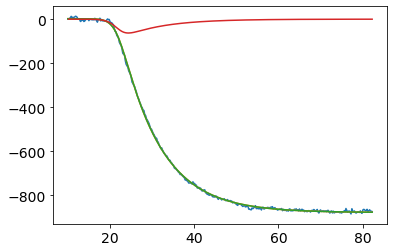

In [30]:
plt.plot(data.loc[data['Mass_sigmoid'].dropna().index,'ts'].dropna(),data_fit.loc[data['Mass_sigmoid'].dropna().index,'Mass'].dropna())
plt.plot(data.loc[data['Mass_sigmoid'].dropna().index,'ts'].dropna(),data['Mass_sigmoid'].dropna())
# plt.plot(data['ts'],data['Mass'].diff()/data['ts'].diff())
plt.plot(data.loc[data['Mass_sigmoid'].dropna().index,'ts'].dropna(),data['Mass_sigmoid'].dropna())
plt.plot(data.loc[data['Mass_sigmoid'].dropna().index,'ts'].dropna(),data['Mass_sigmoid'].dropna().diff()/data.loc[data['Mass_sigmoid'].dropna().index,'ts'].diff())

In [31]:
pipette.liquid.dispense(1000, speed=initial_flow_rate_aspirate)


Dispensing 1000.0 uL...
Target: 1000.0 uL at 50.34 uL/s...
Best parameters: SpeedParameters(preset=945, intervals=18, step_size=22, delay=1.0448176386462706)
SpeedParameters(preset=945, intervals=18, step_size=22, delay=1.0448176386462706)
Speed 5: 945 uL/s
Dispense time: 20.032356499999878s


'ok'

In [24]:

fig = make_subplots(rows=2, cols=4,column_widths=[0.011]*4,horizontal_spacing=0.09)

colours= [['#1f77b4','#ff7f0e'],['#2ca02c','#d62728']]

column = 1
for key in ['204','1275']:
    fig.add_trace(
        go.Scatter(x=mass_data[key]['ts'], y=mass_data[key]['Mass'],mode='lines',marker_color=colours[column-1][0]),
        row=1, col=column
    )
    fig.add_trace(
        go.Scatter(x=mass_data[key]['ts'], y=mass_data[key]['Mass_smooth'],mode='lines',marker_color=colours[column-1][1]),
        row=1, col=column
    )
    fig.add_trace(
        go.Scatter(x=mass_data[key]['ts'], y=mass_data[key]['Mass'].diff()/mass_data[key]['ts'].diff(),mode='lines',marker_color=colours[column-1][0]),
        row=2, col=column
    )
    fig.add_trace(
        go.Scatter(x=mass_data[key]['ts'], y=mass_data[key]['Mass_derivative_smooth']/mass_data[key]['ts'].diff(),mode='lines',marker_color=colours[column-1][1]),
        row=2, col=column
    )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',showticklabels=False,mirror=True,row=1,col=column,tickfont= dict(size=14), titlefont=dict(size=18))
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',mirror=True,title_text= 'Mass<br>[mg]',row=1,col=column,tickfont= dict(size=14), titlefont=dict(size=18))
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',mirror=True,title_text= 'Time<br>[s]',row=2,col=column,tickfont= dict(size=14), titlefont=dict(size=18))
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',mirror=True,title_text= 'dMass/dTime<br>[mg/s]',row=2,col=column,tickfont= dict(size=14), titlefont=dict(size=18))
    column+=1

for key in  ['204','1275']:
    fig.add_trace(
        go.Scatter(x=mass_data[key]['ts'], y=mass_data[key]['Mass'],mode='lines',marker_color=colours[(column-3)][0]),
        row=1, col=column
    )
    fig.add_trace(
        go.Scatter(x=mass_data[key]['ts'], y=mass_data[key]['Mass_sigmoid'],mode='lines',marker_color=colours[(column-3)][1]),
        row=1, col=column
    )
    fig.add_trace(
        go.Scatter(x=mass_data[key]['ts'], y=mass_data[key]['Mass'].diff()/mass_data[key]['ts'].diff(),mode='lines',marker_color=colours[(column-3)][0]),
        row=2, col=column
    )
    fig.add_trace(
        go.Scatter(x=mass_data[key].loc[mass_data[key]['Mass_sigmoid'].dropna().index,'ts'], y=mass_data[key]['Mass_sigmoid'].dropna().diff()/mass_data[key].loc[mass_data[key]['Mass_sigmoid'].dropna().index,'ts'].diff(),mode='lines',marker_color=colours[(column-3)][1]),
        row=2, col=column
    )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',showticklabels=False,mirror=True,row=1,col=column)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',mirror=True,title_text= 'Mass<br>[mg]',row=1,col=column,tickfont= dict(size=14), titlefont=dict(size=18))
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',mirror=True,title_text= 'Time<br>[s]',row=2,col=column,tickfont= dict(size=14), titlefont=dict(size=18))
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',ticks='outside',mirror=True,title_text= 'dMass/dTime<br>[mg/s]',row=2,col=column,tickfont= dict(size=14), titlefont=dict(size=18))
    column+=1

fig.update_layout(width = 1500, height = 700,
                  plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor = 'rgba(255,255,255,255)',showlegend=False)

NameError: name 'make_subplots' is not defined

### Loop pipetting using 5 point initialisation parameters

In [34]:
pipette.mover.safeMoveTo(source.wells['A1'].top)
pipette.liquid.blowout(home=False) 
time.sleep(5)
pipette.liquid.home()
pipette.touchTip(source.wells['A1'])
time.sleep(10)

pipette.liquid.blowout(home=False) 
time.sleep(5)
pipette.liquid.home()
pipette.touchTip(source.wells['A1'])
time.sleep(10)

pipette.liquid.blowout(home=False) 
time.sleep(5)
pipette.liquid.home()
pipette.touchTip(source.wells['A1'])
time.sleep(10)


SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,118.400000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 118.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 0.500s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.866176,-145.139761,108.400000,10.000000,0.000000,0.000000)
Move time: 0.422s (0.200x)
[200.866 -145.140 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50

In [35]:
# New dataframe
df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate','blow_out', 'delay_aspirate', 'delay_dispense', 'delay_blow_out', 'density', 'time', 'm', '%error'])
df = df.astype({'liquid':str,'pipette':str,'blow_out':bool})


In [36]:
liquids_dict = {
  liquid_name :{ # why so many dict #askpablo
        "rLine1000": {
            "aspiration_rate": initial_flow_rate_aspirate,
            "dispense_rate": initial_flow_rate_aspirate,
            "blow_out" : False,
            "delay_aspirate" : 10, 
            "delay_dispense" : 10, 
            "delay_blow_out" : 0, 
            },
    }

}

In [37]:
#Check if new tip is required
pipette.mover.setSpeed(50)
pipette.mover.setHandedness(False)

# initial_liquid_level_source = 50

if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#setup for loops
#TO BE CHANGED (sometimes)
iterations = 5
volumes_list = [1000, 500, 300]

#NOT TO BE CHANGED
liquid_level = initial_liquid_level_source
counter = 1

#while loop
while counter <= iterations:

    #hardcoding aspirate and dispense rates:
    if counter == 1:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = initial_flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = initial_flow_rate_aspirate
    if counter == 2:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 1.25 * initial_flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 1.25 * initial_flow_rate_aspirate
    if counter == 3:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 1.25 * initial_flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 0.1 * initial_flow_rate_aspirate
    if counter == 4:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 0.1 * initial_flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 1.25 * initial_flow_rate_aspirate
    if counter == 5:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 0.1 * initial_flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 0.1 * initial_flow_rate_aspirate


    #for loop
    for volume in volumes_list:
        #liquid transfer
        #transfer start
        start = time.time() 

        #aspirate step
        pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-5))) 
        pipette.liquid.aspirate(volume, speed=liquids_dict[liquid_name][pipette_name]['aspiration_rate'])
        time.sleep(liquids_dict[liquid_name][pipette_name]['delay_aspirate'])

        pipette.touchTip(source.wells['A1']) 

        #dispense step
        pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-5))) 
        balance.tare() 
        balance.clearCache() 
        balance.toggleRecord(True) 
        time.sleep(5)
        pipette.liquid.dispense(volume, speed=liquids_dict[liquid_name][pipette_name]['dispense_rate'])
        time.sleep(liquids_dict[liquid_name][pipette_name]['delay_dispense'])

        #blowout step
        if liquids_dict[liquid_name][pipette_name]['blow_out'] == True: 
            pipette.liquid.blowout(home=False)
            time.sleep(liquids_dict[liquid_name][pipette_name]['delay_blow_out']) 

        #transfer termination
        finish = time.time() 
        time_m = finish - start

        pipette.mover.safeMoveTo(source.wells['A1'].top) 
        time.sleep(5)
        balance.toggleRecord(False) 
        if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
            pipette.liquid.home() 

        #do blowout
        pipette.mover.safeMoveTo(source.wells['A1'].top)
        
        pipette.liquid.blowout(home=False) 
        time.sleep(5)
        pipette.liquid.home()
        pipette.touchTip(source.wells['A1'])
        time.sleep(5)

        pipette.liquid.blowout(home=False) 
        time.sleep(5)
        pipette.liquid.home()
        pipette.touchTip(source.wells['A1'])
        time.sleep(5)

        pipette.liquid.blowout(home=False) 
        time.sleep(5)
        pipette.liquid.home()
        pipette.touchTip(source.wells['A1'])
        time.sleep(5)


        #record transfer values 
        #calculating mass error functions
        m = (balance.buffer_df.iloc[-10:,-1].mean()-balance.buffer_df.iloc[:10,-1].mean())/1000 
        error = (m-density*volume/1000)/(density/1000*volume)*100

        #making new dataframe + filling it in
        df = pd.concat([df,pd.DataFrame(liquids_dict[liquid_name][pipette_name],index=[0])],ignore_index=True)
        df.iloc[-1,-3] = time_m
        df.iloc[-1,2] = volume
        df.iloc[-1, 0] = liquid_name
        df.iloc[-1, 1] = pipette_name
        df.iloc[-1,-4] = density
        df.iloc[-1, -2] = m
        df.iloc[-1,-1]= error

        #change liquid levels
        liquid_level = liquid_level - 2*m/density   

        #printing checks
        print("LIQUID LEVEL: " +str(liquid_level) + "   LIQUID CHANGE: " +str(1.2*m/density) + "   ITERATION: " + str(counter) + ", " + "VOLUME: " + str(volume))    

        #liquid level checks
        if (1.2*m/density > 1.2) or (1.2*m/density < 0):
            break
        if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
            break
     #liquid level checks
    if (1.2*m/density > 1.2) or (1.2*m/density < 0):
        break
    if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
        break
    
    counter += 1



Tip capacitance: 249
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,94.900000,10.000000,0.000000,0.000000)
Move time: 1.051s (1.000x)
[200.736 -153.589 94.900], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 50.34 uL/s...
Best parameters: SpeedParameters(preset=945, intervals=18, step_size=22, delay=1.0448176386462706)
SpeedParameters(preset=945, intervals=18, step_size=22, delay=1.0448176386462706)
Speed 5: 945 uL/s
Aspiration time: 20.017679699998553s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move ti

In [16]:
df

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error
0,Viscous_std_817,rLine1000,1000,74.260,74.260,False,10,10,0,0.8466,85.208091,0.664415,-21.519609
1,Viscous_std_817,rLine1000,500,74.260,74.260,False,10,10,0,0.8466,71.74596,0.382536,-9.629996
2,Viscous_std_817,rLine1000,300,74.260,74.260,False,10,10,0,0.8466,66.419948,0.221977,-12.600678
3,Viscous_std_817,rLine1000,1000,92.825,92.825,False,10,10,0,0.8466,79.90049,0.595377,-29.674354
4,Viscous_std_817,rLine1000,500,92.825,92.825,False,10,10,0,0.8466,69.198397,0.396364,-6.363279
5,Viscous_std_817,rLine1000,300,92.825,92.825,False,10,10,0,0.8466,64.870558,0.232293,-8.538796
6,Viscous_std_817,rLine1000,1000,92.825,7.426,False,10,10,0,0.8466,204.231302,0.789421,-6.753977
7,Viscous_std_817,rLine1000,500,92.825,7.426,False,10,10,0,0.8466,131.379168,0.387447,-8.46995
8,Viscous_std_817,rLine1000,300,92.825,7.426,False,10,10,0,0.8466,102.34818,0.233517,-8.056877
9,Viscous_std_817,rLine1000,1000,7.426,92.825,False,10,10,0,0.8466,204.644334,0.604557,-28.590038


In [40]:
liq.set_data(df)
liq._data

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,time_asp_1000,acq_value
0,Viscous_std_1275,rLine1000,1000,50.340,50.340,False,10,10,0,0.8736,98.195887,0.600419,-31.270772,59.729837,None
1,Viscous_std_1275,rLine1000,500,50.340,50.340,False,10,10,0,0.8736,78.22956,0.362938,-16.90979,59.729837,None
2,Viscous_std_1275,rLine1000,300,50.340,50.340,False,10,10,0,0.8736,71.495706,0.201592,-23.080064,59.729837,None
3,Viscous_std_1275,rLine1000,"mean[300, 500, 1000]",50.340,50.340,False,10,10,0,0.8736,98.195887,0.600419,-23.753542,59.729837,None
4,Viscous_std_1275,rLine1000,1000,62.925,62.925,False,10,10,0,0.8736,90.435932,0.543533,-37.782419,51.78387,None
5,Viscous_std_1275,rLine1000,500,62.925,62.925,False,10,10,0,0.8736,74.269061,0.363142,-16.863087,51.78387,None
6,Viscous_std_1275,rLine1000,300,62.925,62.925,False,10,10,0,0.8736,67.968719,0.195078,-25.565298,51.78387,None
7,Viscous_std_1275,rLine1000,"mean[300, 500, 1000]",62.925,62.925,False,10,10,0,0.8736,90.435932,0.543533,-26.736935,51.78387,None
8,Viscous_std_1275,rLine1000,1000,62.925,5.034,False,10,10,0,0.8736,273.467967,0.768759,-12.001036,234.54112,None
9,Viscous_std_1275,rLine1000,500,62.925,5.034,False,10,10,0,0.8736,166.003394,0.356294,-18.430953,234.54112,None


In [72]:
pipette.mover.safeMoveTo(source.wells['A1'].top)

pipette.liquid.blowout(home=False) 
time.sleep(5)
pipette.liquid.home()
pipette.touchTip(source.wells['A1'])
time.sleep(5)

pipette.liquid.blowout(home=False) 
time.sleep(5)
pipette.liquid.home()
pipette.touchTip(source.wells['A1'])
time.sleep(5)

pipette.liquid.blowout(home=False) 
time.sleep(5)
pipette.liquid.home()
pipette.touchTip(source.wells['A1'])
time.sleep(5)



SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(226.797920,-247.001909,200.000000,10.000000,0.000000,0.000000)
Move time: 0.111s (1.000x)
[226.798 -247.002 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 1.868s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,118.400000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 118.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 0.500s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.866176,-145.139761,108.400000,10.000000,0.000000,0.000000)
Move time: 0.422s (0.200x)
[200.866 -145.140 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50

In [41]:
#Check if new tip is required
pipette.mover.setSpeed(50)
pipette.mover.setHandedness(False)

if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#setup for loops
#TO BE CHANGED
iterations = 5
volumes_list = [1000, 500, 300]

#NOT TO BE CHANGED
# liquid_level = initial_liquid_level
counter = 1

#while loop
while counter <= iterations:
    #getting botorch suggestions + implementing it in liquids_dict
    liq.optimized_suggestions()
    liquids_dict = {
    liquid_name :{
            "rLine1000": {
                "aspiration_rate": liq._latest_suggestion['aspiration_rate'], 
                "dispense_rate": liq._latest_suggestion['dispense_rate'], 
                "blow_out" : False, 
                "delay_aspirate" : 10, 
                "delay_dispense" : 10, 
                "delay_blow_out" : 0, 
                },
        }
    }
    #for loop
    for item in volumes_list:
        volume = item
        #liquid transfer
        #transfer start
        start = time.time() 

        #aspirate step
        pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-5))) 
        pipette.liquid.aspirate(volume, speed=liquids_dict[liquid_name][pipette_name]['aspiration_rate'])
        time.sleep(liquids_dict[liquid_name][pipette_name]['delay_aspirate'])

        pipette.touchTip(source.wells['A1']) 

        #dispense step
        pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-5))) 
        balance.tare() 
        balance.clearCache() 
        balance.toggleRecord(True) 
        time.sleep(5)
        pipette.liquid.dispense(volume, speed=liquids_dict[liquid_name][pipette_name]['dispense_rate'])
        time.sleep(liquids_dict[liquid_name][pipette_name]['delay_dispense'])

        #blowout step
        if liquids_dict[liquid_name][pipette_name]['blow_out'] == True: 
            pipette.liquid.blowout(home=False)
            time.sleep(liquids_dict[liquid_name][pipette_name]['delay_blow_out']) 

        #transfer termination
        finish = time.time() 
        time_m = finish - start

        pipette.mover.safeMoveTo(source.wells['A1'].top) 
        time.sleep(5)
        balance.toggleRecord(False) 
        if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
            pipette.liquid.home() 

        #do blowout
        pipette.mover.safeMoveTo(source.wells['A1'].top)
        
        pipette.liquid.blowout(home=False) 
        time.sleep(5)
        pipette.liquid.home()
        pipette.touchTip(source.wells['A1'])
        time.sleep(5)

        pipette.liquid.blowout(home=False) 
        time.sleep(5)
        pipette.liquid.home()
        pipette.touchTip(source.wells['A1'])
        time.sleep(5)

        pipette.liquid.blowout(home=False) 
        time.sleep(5)
        pipette.liquid.home()
        pipette.touchTip(source.wells['A1'])
        time.sleep(5)

        #record transfer values 
        #calculating mass error functions
        m = (balance.buffer_df.iloc[-10:,-1].mean()-balance.buffer_df.iloc[:10,-1].mean())/1000 
        error = (m-density*volume/1000)/(density/1000*volume)*100

        #making new dataframe + filling it in
        df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate','blow_out', 'delay_aspirate', 'delay_dispense', 'delay_blow_out', 'density', 'time', 'm', '%error', 'acq_value'])
        df = df.astype({'liquid':str,'pipette':str,'blow_out':bool})
        df = pd.concat([df,pd.DataFrame(liquids_dict[liquid_name][pipette_name],index=[0])],ignore_index=True)
        df.iloc[-1,-4] = time_m
        df.iloc[-1,2] = volume
        df.iloc[-1, 0] = liquid_name
        df.iloc[-1, 1] = pipette_name
        df.iloc[-1,-5] = density
        df.iloc[-1, -3] = m
        df.iloc[-1,-2]= error
        df.iloc[-1, -1] = liq._latest_acq_value

        #change liquid levels
        liquid_level = liquid_level - 2*m/density   

        #printing checks
        print("LIQUID LEVEL: " +str(liquid_level) + "   LIQUID CHANGE: " +str(1.2*m/density) + "   ITERATION: " + str(counter) + ", " + str(volume))     

        #liquid level checks
        if (1.2*m/density > 1.2) or (1.2*m/density < 0):
            break
        if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
            break

        #update main dataframe
        liq.update_data(df)
    if (1.2*m/density > 1.2) or (1.2*m/density < 0):
        break
    if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
        break   
    counter += 1





Tip capacitance: 249
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,80.301903,10.000000,0.000000,0.000000)
Move time: 1.197s (1.000x)
[200.736 -153.589 80.302], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 26.70745163371135 uL/s...
Best parameters: SpeedParameters(preset=945, intervals=35, step_size=11, delay=1.0395580762002783)
SpeedParameters(preset=945, intervals=35, step_size=11, delay=1.0395580762002783)
Speed 5: 945 uL/s
Aspiration time: 37.63951160000033s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.0000

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,78.555767,10.000000,0.000000,0.000000)
Move time: 1.214s (1.000x)
[200.736 -153.589 78.556], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 500.0 uL...
Target: 500.0 uL at 26.70745163371135 uL/s...
Best parameters: SpeedParameters(preset=265, intervals=16, step_size=12, delay=1.0521609006109505)
SpeedParameters(preset=265, intervals=16, step_size=12, delay=1.0521609006109505)
Speed 2: 265 uL/s
Aspiration time: 18.801758500001597s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.492s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,77.683400,10.000000,0.000000,0.000000)
Move time: 1.223s (1.000x)
[200.736 -153.589 77.683], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 26.70745163371135 uL/s...
Best parameters: SpeedParameters(preset=410, intervals=10, step_size=12, delay=1.0501112800490067)
SpeedParameters(preset=410, intervals=10, step_size=12, delay=1.0501112800490067)
Speed 3: 410 uL/s
Aspiration time: 11.318117200000415s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.536s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,77.218511,10.000000,0.000000,0.000000)
Move time: 1.228s (1.000x)
[200.736 -153.589 77.219], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 8.811052288793029 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=40, step_size=10, delay=2.6706788830582)
SpeedParameters(preset=150, intervals=40, step_size=10, delay=2.6706788830582)
Speed 1: 150 uL/s
Aspiration time: 113.84930030000032s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.559s (0.2

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,75.524182,10.000000,0.000000,0.000000)
Move time: 1.245s (1.000x)
[200.736 -153.589 75.524], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 500.0 uL...
Target: 500.0 uL at 8.811052288793029 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=20, step_size=10, delay=2.6706788830582)
SpeedParameters(preset=150, intervals=20, step_size=10, delay=2.6706788830582)
Speed 1: 150 uL/s
Aspiration time: 56.936606699997355s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.644s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.86617

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,74.618356,10.000000,0.000000,0.000000)
Move time: 1.254s (1.000x)
[200.736 -153.589 74.618], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 8.811052288793029 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=12, step_size=10, delay=2.6706788830581996)
SpeedParameters(preset=150, intervals=12, step_size=10, delay=2.6706788830581996)
Speed 1: 150 uL/s
Aspiration time: 34.16111980000278s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.689s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,74.102695,10.000000,0.000000,0.000000)
Move time: 1.259s (1.000x)
[200.736 -153.589 74.103], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 8.500265963955783 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=40, step_size=10, delay=2.774417777750612)
SpeedParameters(preset=150, intervals=40, step_size=10, delay=2.774417777750612)
Speed 1: 150 uL/s
Aspiration time: 117.9498205000018s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.715s (

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,72.152937,10.000000,0.000000,0.000000)
Move time: 1.278s (1.000x)
[200.736 -153.589 72.153], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 500.0 uL...
Target: 500.0 uL at 8.500265963955783 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=20, step_size=10, delay=2.774417777750612)
SpeedParameters(preset=150, intervals=20, step_size=10, delay=2.774417777750612)
Speed 1: 150 uL/s
Aspiration time: 58.970403300001635s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.812s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.8

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,71.207147,10.000000,0.000000,0.000000)
Move time: 1.288s (1.000x)
[200.736 -153.589 71.207], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 8.500265963955783 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=12, step_size=10, delay=2.774417777750612)
SpeedParameters(preset=150, intervals=12, step_size=10, delay=2.774417777750612)
Speed 1: 150 uL/s
Aspiration time: 35.39882149999903s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.860s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.86

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,70.654325,10.000000,0.000000,0.000000)
Move time: 1.293s (1.000x)
[200.736 -153.589 70.654], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 62.73966500698776 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=9, step_size=44, delay=1.0302459404717887)
SpeedParameters(preset=150, intervals=9, step_size=44, delay=1.0302459404717887)
Speed 1: 150 uL/s
Aspiration time: 16.016311600000336s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.887s 

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,69.264295,10.000000,0.000000,0.000000)
Move time: 1.307s (1.000x)
[200.736 -153.589 69.264], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 500.0 uL...
Target: 500.0 uL at 62.73966500698776 uL/s...
Best parameters: SpeedParameters(preset=945, intervals=7, step_size=28, delay=1.0629056480508363)
SpeedParameters(preset=945, intervals=7, step_size=28, delay=1.0629056480508363)
Speed 5: 945 uL/s
Aspiration time: 8.042580600002111s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.957s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.86

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,68.455476,10.000000,0.000000,0.000000)
Move time: 1.315s (1.000x)
[200.736 -153.589 68.455], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 62.73966500698776 uL/s...
Best parameters: SpeedParameters(preset=650, intervals=4, step_size=30, delay=1.080031394433842)
SpeedParameters(preset=650, intervals=4, step_size=30, delay=1.080031394433842)
Speed 4: 650 uL/s
Aspiration time: 4.801875999997719s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 1.997s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.8661

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,68.012871,10.000000,0.000000,0.000000)
Move time: 1.320s (1.000x)
[200.736 -153.589 68.013], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 26.60247998877056 uL/s...
Best parameters: SpeedParameters(preset=650, intervals=35, step_size=11, delay=1.030057678955848)
SpeedParameters(preset=650, intervals=35, step_size=11, delay=1.030057678955848)
Speed 4: 650 uL/s
Aspiration time: 37.8804624000004s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 2.019s (0

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,66.605628,10.000000,0.000000,0.000000)
Move time: 1.334s (1.000x)
[200.736 -153.589 66.606], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 500.0 uL...
Target: 500.0 uL at 26.60247998877056 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=15, step_size=13, delay=1.0307937878416513)
SpeedParameters(preset=150, intervals=15, step_size=13, delay=1.0307937878416513)
Speed 1: 150 uL/s
Aspiration time: 18.939179900000454s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 2.090s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,65.743302,10.000000,0.000000,0.000000)
Move time: 1.343s (1.000x)
[200.736 -153.589 65.743], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 26.60247998877056 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=9, step_size=13, delay=1.0307937878416515)
SpeedParameters(preset=150, intervals=9, step_size=13, delay=1.0307937878416515)
Speed 1: 150 uL/s
Aspiration time: 11.3573101999973s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000000)
Move time: 2.133s (0.200x)
[200.736 -153.589 108.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.866

C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppData\Local\Temp/ipykernel_20648/3055701501.py:32: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
C:\Users\QUIJAN~1\AppD

In [42]:
liq._data

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,time_asp_1000,acq_value
0,Viscous_std_1275,rLine1000,1000,50.340000,50.340000,False,10,10,0,0.8736,98.195887,0.600419,-31.270772,59.729837,None
1,Viscous_std_1275,rLine1000,500,50.340000,50.340000,False,10,10,0,0.8736,78.22956,0.362938,-16.90979,59.729837,None
2,Viscous_std_1275,rLine1000,300,50.340000,50.340000,False,10,10,0,0.8736,71.495706,0.201592,-23.080064,59.729837,None
3,Viscous_std_1275,rLine1000,"mean[300, 500, 1000]",50.340000,50.340000,False,10,10,0,0.8736,98.195887,0.600419,-23.753542,59.729837,None
4,Viscous_std_1275,rLine1000,1000,62.925000,62.925000,False,10,10,0,0.8736,90.435932,0.543533,-37.782419,51.78387,None
5,Viscous_std_1275,rLine1000,500,62.925000,62.925000,False,10,10,0,0.8736,74.269061,0.363142,-16.863087,51.78387,None
6,Viscous_std_1275,rLine1000,300,62.925000,62.925000,False,10,10,0,0.8736,67.968719,0.195078,-25.565298,51.78387,None
7,Viscous_std_1275,rLine1000,"mean[300, 500, 1000]",62.925000,62.925000,False,10,10,0,0.8736,90.435932,0.543533,-26.736935,51.78387,None
8,Viscous_std_1275,rLine1000,1000,62.925000,5.034000,False,10,10,0,0.8736,273.467967,0.768759,-12.001036,234.54112,None
9,Viscous_std_1275,rLine1000,500,62.925000,5.034000,False,10,10,0,0.8736,166.003394,0.356294,-18.430953,234.54112,None


In [81]:
liq._data.to

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 0.856s (1.000x)
[232.616 194.961 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 3.899s (0.500x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (1.000x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Homed


True

In [43]:
liq._data.to_csv('full_auto_1275.csv')

In [44]:
pipette.mover.safeMoveTo(bin.wells['A1'].top)
pipette.ejectTip()

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
MovJ(320.000000,-240.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 2.385s (0.500x)
[320.000 -240.000 200.000], [10  0  0]
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 8.699s (0.500x)
[232.616 194.961 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(232.616399,194.960923,114.400000,10.000000,0.000000,0.000000)
Move time: 0.856s (1.000x)
[232.616 194.961 114.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Tip capacitance: 249
Tip capacitance: 249
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 4.280s (0.200x)
[232.616 194.961 200.000], [10  0  0]
SpeedFactor(50)
receiv

array([524.500, 50.000, 70.000])